# Applied Tensorflow

Author: Umberto Michelucci (C) 2017

[um@udata.science](mailto:um@udata.science)

[udata.science](udata.science)

## Abstract

The following notebook contains a practical example on using tensorflow. I explained what I think is necessary, but to understand it completely you need to have a good grasp of Neural Networks, Python and Machine Learning in general.

## Helper Functions

Here is a quick helper function we will use to compare MSE for training and test dataset, to be able to check overfitting.

In [39]:
def compare_mse(sess, y_, train_x, test_x, kp):
    if (kp < 1):
        pred_y = sess.run(y_, feed_dict = {X:test_x, keep_prob:kp})
        mse = tf.reduce_mean(tf.square(pred_y - test_y))
        print("MSE Test: %.4f" % sess.run(mse))

        pred_y = sess.run(y_, feed_dict = {X:train_x, keep_prob:kp})
        mse = tf.reduce_mean(tf.square(pred_y - train_y))
        print("MSE Train: %.4f" % sess.run(mse))
    else:
        pred_y = sess.run(y_, feed_dict = {X:test_x})
        mse = tf.reduce_mean(tf.square(pred_y - test_y))
        print("MSE Test: %.4f" % sess.run(mse))

        pred_y = sess.run(y_, feed_dict = {X:train_x})
        mse = tf.reduce_mean(tf.square(pred_y - train_y))
        print("MSE Train: %.4f" % sess.run(mse))

## Libraries

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np

from sklearn.datasets import load_boston
import sklearn.linear_model as sk

For this demonstration I decided to use the Boston dataset, to have something different than the usual MNIST dataset that everyone is using. Altough I will dedicate a tutorial to that dataset too. First of all let's load the dataset and check it out.

In [5]:
boston = load_boston()
features = np.array(boston.data)
labels = np.array(boston.target)

In [6]:
print(boston["DESCR"])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Usually is better to normalize the different features, since this helps learning. We will do that with this function where we use numpy wonderful vectorized code.

In [7]:
def normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset-mu)/sigma

Let's get the dimension of the data set now

In [8]:
n_training_samples = features.shape[0]
n_dim = features.shape[1]

print('The dataset has',n_training_samples,'training samples.')
print('The dataset has',n_dim,'features.')

The dataset has 506 training samples.
The dataset has 13 features.


So in the variable ```n_training_samples``` we have the number of different input observations, and in the variable ```n_dim``` we have the number of features (or variables if you like) that we have at our disposal.
Let's append the bias to the data...

In [10]:
features_norm = normalize(features)

Now let's check the dimensions of our dataset and labels.

In [11]:
print(features_norm.shape)
print(labels.shape)

(506, 13)
(506,)


Let's build a train and a test sets splitting them randomly 80/20

In [58]:
np.random.seed(42)
rnd = np.random.rand(len(features_norm)) < 0.8

train_x = np.transpose(features_norm[rnd])
train_y = np.transpose(labels[rnd])
test_x = np.transpose(features_norm[~rnd])
test_y = np.transpose(labels[~rnd])

print(train_x.shape)
print(train_y.shape)

(13, 399)
(399,)


Note that in tensorflow we will define the lables (our ```train_y```) as a tensor of dimensions ```(n_training_samples*0.8, 1)``` so we will have to reshape the numpy array that otherwise has dimension ```(n_training_samples*0.8,)```. 

In [64]:
train_y = train_y.reshape(1,len(train_y))
test_y = test_y.reshape(1,len(test_y))

print(train_y.shape)
print(test_y.shape)

(1, 399)
(1, 107)


# Linear Regression

## Let's start with tensorflow modelling for a linear regression

Now keep in mind that is an overkill. We could solve linear regression exactly without the need of using gradient descent or similar optimisation algorithm. But I find it very instructive to see how to build such an easy model with tensorflow. The following diagram explain what kind of neural network we need to perform linear regression. To note is (for those with some more experience with neural networks) that we use one single neuron with an identity activation function. The term $WX+b$ is simply a linear combination of the input plus a constat term (bias) $b$. With $n_x$ we have indicated the number of observations we have at our disposal. $y\_$ is the predicted output given a certain input vector ${\bf x} = (x_1, x_2, ... , x_{n_x})$.

![](images/linear_model.png)

First we define the variables and placeholders we need to build the network above.

In [106]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
learning_rate = tf.placeholder(tf.float32, shape=())
W = tf.Variable(tf.ones([1, n_dim]))
b = tf.Variable(tf.zeros(1))

init = tf.global_variables_initializer()

Then we actually define the actual computation $WX+b$. Additionally we need to define the cost function $J$ we want to minimize. In case of regression this is simply the MSE. Then we choose which optimisation algorithm we want to use (in this case the gradient descent optimizer.

In [107]:
y_ = tf.matmul(W,X)+b
cost = tf.reduce_mean(tf.square(y_-Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

To facilitate testing of several hyperparameters (in this case just the learning rate) we will define a function that will perform the training itself. To be able to call it with several values of the learning rate and see what happens.

In [112]:
def run_linear_model(learning_r, training_epochs, train_obs, train_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    cost_history = np.empty(shape=[1], dtype = float)

    for epoch in range(training_epochs+1):
        sess.run(training_step, feed_dict = {X: train_obs, Y: train_labels, learning_rate: learning_r})
        cost_ = sess.run(cost, feed_dict={ X:train_obs, Y: train_labels, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)
    
        if (epoch % 1000 == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_))
            
    return sess, cost_history

In [113]:
sess, cost_history = run_linear_model(learning_r = 0.01, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

Reached epoch 0 cost J = 613.947144
Reached epoch 1000 cost J = 22.131165
Reached epoch 2000 cost J = 22.081099
Reached epoch 3000 cost J = 22.076544
Reached epoch 4000 cost J = 22.076109
Reached epoch 5000 cost J = 22.076061
Reached epoch 6000 cost J = 22.076057
Reached epoch 7000 cost J = 22.076059
Reached epoch 8000 cost J = 22.076059
Reached epoch 9000 cost J = 22.076054
Reached epoch 10000 cost J = 22.076054


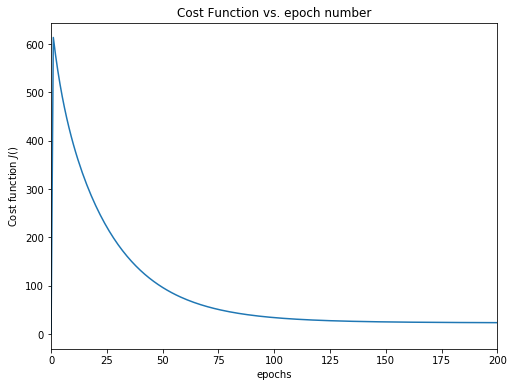

In [69]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim(0,200)
plt.plot(range(len(cost_history)), cost_history)

Let's check the results plotting each observation on a plot where we have on the ```y``` axis the predicted value an on the ```x``` axis the measured value. If the model would get all observations perfectly right all points would be exactly on the diagonal line (that we have marked with a dashed line in the plot). The better the model the more the points aggregrate along the diagonal. The worse the model is the more scattered the points are.

MSE: 23.0605


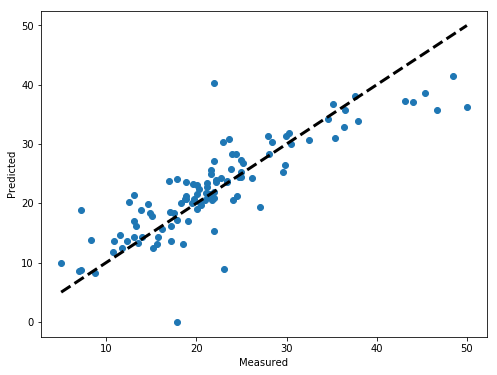

In [70]:
pred_y = sess.run(y_, feed_dict = {X: test_x, Y: test_y})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

To check for overfitting (in case of linear regression this is an almost useless exercise, but I find it instructive) we need to compare the MSE for the train and test set

In [71]:
compare_mse(sess, y_, train_x, test_x, 1)

MSE Test: 23.0605
MSE Train: 22.0761


The two values are comparable.

In [72]:
sess.close()

## Different learning rates

Let's now try different learning rates and see what happens. 

In [73]:
print ('Starting first model')
sess1, cost_history1 = run_linear_model(learning_r = 0.1, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

print ('Starting second model')
sess2, cost_history2 = run_linear_model(learning_r = 0.01, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

print ('Starting third model')
sess3, cost_history3 = run_linear_model(learning_r = 0.001, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

Starting first model
Reached epoch 0 cost J = 373.735
Reached epoch 1000 cost J = 22.0761
Reached epoch 2000 cost J = 22.0761
Reached epoch 3000 cost J = 22.0761
Reached epoch 4000 cost J = 22.0761
Reached epoch 5000 cost J = 22.0761
Reached epoch 6000 cost J = 22.0761
Reached epoch 7000 cost J = 22.0761
Reached epoch 8000 cost J = 22.0761
Reached epoch 9000 cost J = 22.0761
Reached epoch 10000 cost J = 22.0761
Starting second model
Reached epoch 0 cost J = 613.947
Reached epoch 1000 cost J = 22.1312
Reached epoch 2000 cost J = 22.0811
Reached epoch 3000 cost J = 22.0765
Reached epoch 4000 cost J = 22.0761
Reached epoch 5000 cost J = 22.0761
Reached epoch 6000 cost J = 22.0761
Reached epoch 7000 cost J = 22.0761
Reached epoch 8000 cost J = 22.0761
Reached epoch 9000 cost J = 22.0761
Reached epoch 10000 cost J = 22.0761
Starting third model
Reached epoch 0 cost J = 651.28
Reached epoch 1000 cost J = 34.1587
Reached epoch 2000 cost J = 23.4431
Reached epoch 3000 cost J = 22.7519
Reached 

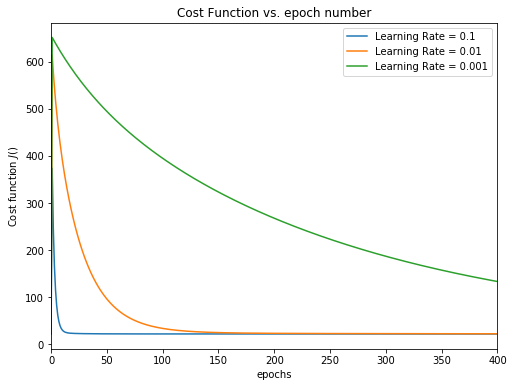

In [76]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim(0,400)
plt.plot(range(len(cost_history1)), cost_history1, label = 'Learning Rate = 0.1')
plt.plot(range(len(cost_history2)), cost_history2, label = 'Learning Rate = 0.01')
plt.plot(range(len(cost_history3)), cost_history3, label = 'Learning Rate = 0.001')
plt.legend(loc = 'upper right')

As expected the higher the learning rate the faster it converges to a low value (the one we expect from the linear model we are using). Note that this is a very trivial model. In real cases what happens is that if the learning rate is too big the model very often will not converge, since it will not be able to converge to a minimum. Several books and blogs discuss this problem at length. 

What we are doing here is a very basic and trivial hypterparameter tuning. To find out which model (in this case which hyperparameters) are the best for our problem. In this case it seems quite clear that a learning rate of 0.1 seems a good choice. It does not require so many epochs to converge to the minimum value we have.

In [77]:
sess1.close()
sess2.close()
sess3.close()

Just to compare our results, let's use sklearn library to perform a classical linear regression. It will be useful to see what MSE we can get from a classical/standard linear regression and compare it with what we get with our neural network. 

**HINT:** the two values should be **very** similar, and they should tend to become the same.

In [99]:
lm = sk.LinearRegression()
lm.fit(np.transpose(train_x), np.transpose(train_y))
msetest = np.mean((np.transpose(test_y)-lm.predict(np.transpose(test_x)))**2)
msetrain = np.mean((np.transpose(train_y)-lm.predict(np.transpose(train_x)))**2)

print('Train MSE=',msetrain)
print('Test MSE=',msetest)

Train MSE= 22.0760561914
Test MSE= 23.0604521841


With our Neural network we got 22.076054 a value that is very close to what we see here of 22.076056. What this tells us, is that our neural network got almost the best possible value we can get. Pretty neat!

**Note** is important to note that this (the one coming from the linear regression) is the minimum value we can get for the cost function. To do better we need to use a more complex model, a non linear model. To see what we can do let's try to use more complex network architecture, but let's start with something easy. Remember we have only 13 features and (in the training set) roughly 400 observations. So we need to be aware that it will be easy to overfit the training data. This is why is important to have a test dataset at our disposal to check this.

## Neural Network models

## 1 layer network with ReLu activation functions

Now we will start building neural networks. Let's start with something easy. Let's consider a neural network with just one hidden layer with $n_1$ neurons and with an output layer of one neuron. For simplicity we will consider for each neuron the same activation function that we will indicate with $f()$. The following diagram shows the architecture of the network.

For this section we will use as activation function the [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) functions.

![](images/NN-1-layer.png)

In [126]:
tf.reset_default_graph()


# Number of neurons in the hidden layer
n1 = 5

cost_history = np.empty(shape=[1], dtype = float)

learning_rate = tf.placeholder(tf.float32, shape=())

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
W1 = tf.Variable(tf.random_normal([n1, n_dim], stddev=1))
b1 = tf.Variable(tf.ones([n1,1]))
W2 = tf.Variable(tf.random_normal([1,n1], stddev=1))
b2 = tf.Variable(tf.zeros(1))

init = tf.global_variables_initializer()

# Let's build our network...
Z1 = tf.nn.relu(tf.matmul(W1,X)+b1)
y_ = tf.nn.relu(tf.matmul(W2,Z1)+b2)


cost = tf.reduce_mean(tf.square(y_-Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [127]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

training_epochs = 5000
    
cost_history = []
for epoch in range(training_epochs+1):

    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y, learning_rate: 0.01})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y, learning_rate: 0.01})
    cost_history = np.append(cost_history, cost_)
    
    if (epoch % 1000 == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Reached epoch 0 cost J = 424.7
Reached epoch 1000 cost J = 9.34723
Reached epoch 2000 cost J = 8.21282
Reached epoch 3000 cost J = 8.0678
Reached epoch 4000 cost J = 8.04186
Reached epoch 5000 cost J = 7.82219


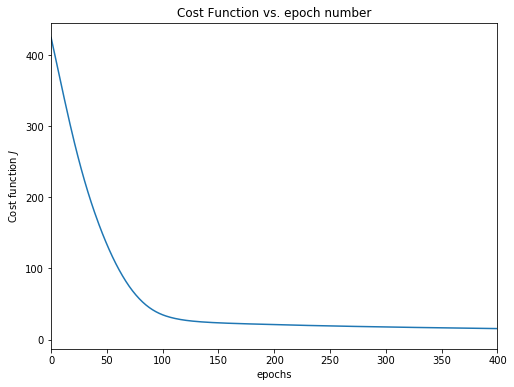

In [128]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.xlim((0,400))
plt.ylabel("Cost function $J$")
plt.plot(range(len(cost_history)), cost_history)

MSE: 7.8222


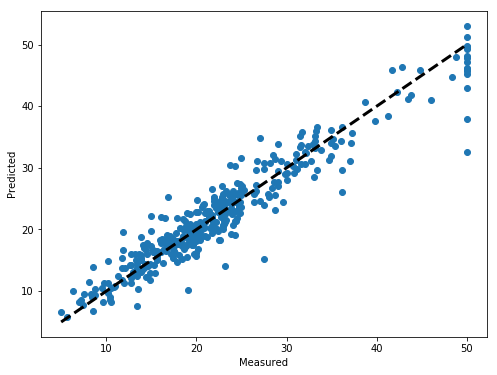

In [129]:
pred_y = sess.run(y_, feed_dict = {X:train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

MSE: 16.6859


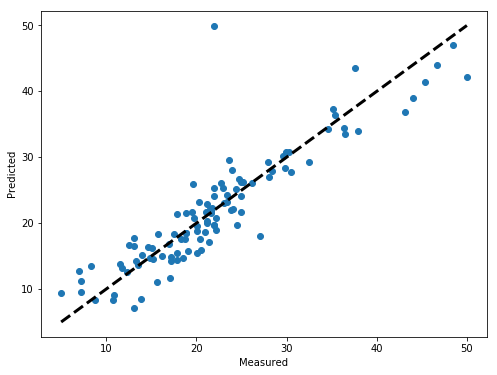

In [130]:
pred_y = sess.run(y_, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Let's check for overfitting...

In [131]:
compare_mse(sess, y_, train_x, test_x, 1.0)

MSE Test: 16.6859
MSE Train: 7.8222


In [85]:
sess.close()

## 2 layer network with relu

In [146]:
tf.reset_default_graph()

learning_rate = 0.01
training_epochs = 15000

# Number of neurons in the layers
n1 = 5 # Number of neurons in layer 1
n2 = 5 # Number of neurons in layer 2

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
W1 = tf.Variable(tf.random_normal([n1, n_dim], stddev=1))
b1 = tf.Variable(tf.ones([n1,1]))
W2 = tf.Variable(tf.random_normal([n2, n1], stddev=1))
b2 = tf.Variable(tf.ones([n2,1]))
W3 = tf.Variable(tf.random_normal([1, n2], stddev=1))
b3 = tf.Variable(tf.ones(1))



# Let's build our network...
Z1 = tf.nn.relu(tf.matmul(W1, X) + b1)
Z2 = tf.nn.relu(tf.matmul(W2, Z1) + b2)
y_ = tf.nn.relu(tf.matmul(W3, Z2) + b3)


cost = tf.reduce_mean(tf.square(y_-Y))
#training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [147]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
cost_history = []
for epoch in range(training_epochs+1):
    
    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y})
    cost_history = np.append(cost_history, cost_)
    
    if (epoch % 1000 == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Reached epoch 0 cost J = 226.356
Reached epoch 1000 cost J = 8.31852
Reached epoch 2000 cost J = 6.79934
Reached epoch 3000 cost J = 5.63402
Reached epoch 4000 cost J = 4.82978
Reached epoch 5000 cost J = 4.57259
Reached epoch 6000 cost J = 4.54844
Reached epoch 7000 cost J = 4.53046
Reached epoch 8000 cost J = 4.33368
Reached epoch 9000 cost J = 4.29926
Reached epoch 10000 cost J = 4.29243
Reached epoch 11000 cost J = 4.29048
Reached epoch 12000 cost J = 4.28691
Reached epoch 13000 cost J = 4.28838
Reached epoch 14000 cost J = 4.27852
Reached epoch 15000 cost J = 4.28007


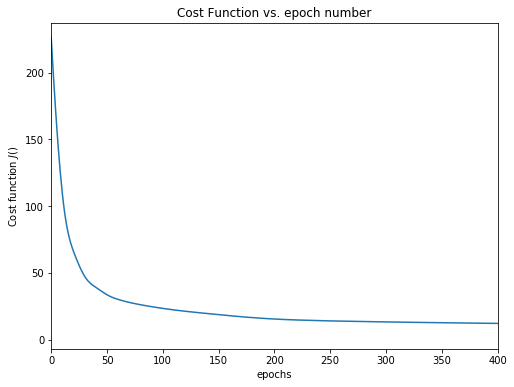

In [155]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim(0,400)
plt.plot(range(len(cost_history)), cost_history)

In [149]:
compare_mse(sess, y_, train_x, test_x,1)

MSE Test: 14.8338
MSE Train: 4.2801


MSE: 14.8338


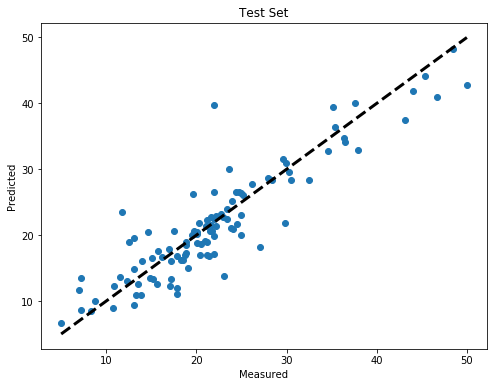

In [150]:
pred_y = sess.run(y_, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Test Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Let's see how good we do on the training set

MSE: 4.2801


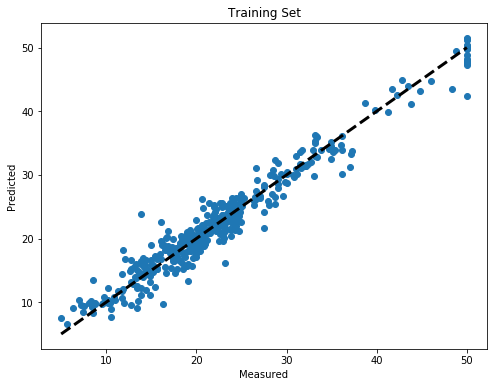

In [151]:
pred_y = sess.run(y_, feed_dict = {X:train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Training Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## 2 Layer network with sigmoid activation function for the hidden layers

In [156]:
tf.reset_default_graph()

learning_rate = 0.1
training_epochs = 10000
visualisation_step = 1000

# Number of neurons in the layers
n1 = 10
n2 = 10

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
W1 = tf.Variable(tf.random_normal([n1, n_dim], stddev=1))
b1 = tf.Variable(tf.ones([n1,1]))
W2 = tf.Variable(tf.random_normal([n2, n1], stddev=1))
b2 = tf.Variable(tf.ones([n2,1]))
W3 = tf.Variable(tf.random_normal([1, n2], stddev=1))
b3 = tf.Variable(tf.ones(1))



# Let's build our network...
Z1 = tf.nn.sigmoid(tf.matmul(W1, X) + b1)
Z2 = tf.nn.sigmoid(tf.matmul(W2, Z1) + b2)
y_ = tf.matmul(W3, Z2) + b3


cost = tf.reduce_mean(tf.square(y_-Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


init = tf.global_variables_initializer()


In [157]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
        
print ('Adam optimisation')
cost_history_adam = []
for epoch in range(training_epochs+1):
    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y})
    cost_history_adam = np.append(cost_history_adam, cost_)
    
    if (epoch % visualisation_step == 0):
        print("Reached epoch",epoch,"cost J =", cost_)


Adam optimisation
Reached epoch 0 cost J = 464.665
Reached epoch 1000 cost J = 1.84895
Reached epoch 2000 cost J = 1.3977
Reached epoch 3000 cost J = 1.13341
Reached epoch 4000 cost J = 1.05674
Reached epoch 5000 cost J = 1.02434
Reached epoch 6000 cost J = 1.02647
Reached epoch 7000 cost J = 0.890406
Reached epoch 8000 cost J = 0.849935
Reached epoch 9000 cost J = 0.769012
Reached epoch 10000 cost J = 0.765331


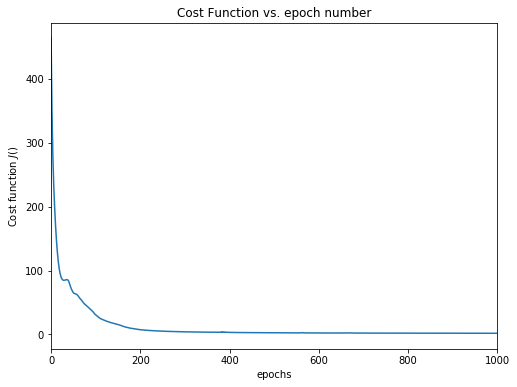

In [158]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim((0,1000))
plt.plot(range(len(cost_history_adam)), cost_history_adam)

MSE: 24.2907


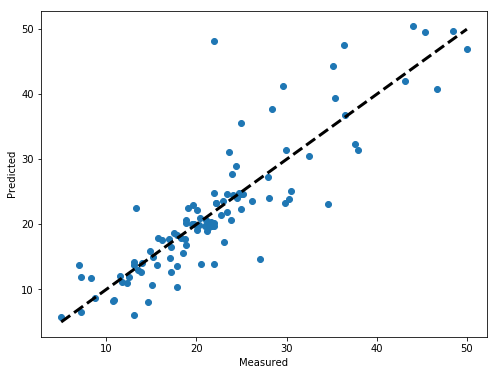

In [160]:
pred_y = sess.run(y_, feed_dict = {X:test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [162]:
compare_mse(sess, y_, train_x, test_x,1)

MSE Test: 24.2907
MSE Train: 0.7653


Overfitting...

Let's see how good we do on the training set

MSE: 0.7653


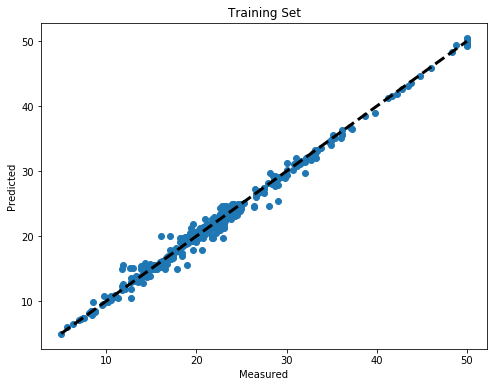

In [163]:
pred_y = sess.run(y_, feed_dict = {X:train_x})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Training Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

This is a CLEAR case of overfitting!

In [62]:
sess.close()

## Regularisation with dropout

Let's build a model with dropout (regularization)

In [164]:
tf.reset_default_graph()

learning_rate = 0.1
visualisation_step = 1000


# Number of neurons in the layers
n1 = 5
n2 = 5

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
W1 = tf.Variable(tf.random_normal([n1, n_dim], stddev=1))
b1 = tf.Variable(tf.ones([n1,1]))
W2 = tf.Variable(tf.random_normal([n2, n1], stddev=1))
b2 = tf.Variable(tf.ones([n2,1]))
W3 = tf.Variable(tf.random_normal([1, n2], stddev=1))
b3 = tf.Variable(tf.ones(1))



# Let's build our network...
Z1 = tf.nn.sigmoid(tf.matmul(W1, X) + b1)
Z2 = tf.nn.sigmoid(tf.matmul(W2, Z1) + b2)
y_ = tf.matmul(W3, Z2) + b3

keep_prob = tf.placeholder(tf.float32)

cost = tf.reduce_mean(tf.square(y_-Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [165]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
     
kp = 0.75
training_epochs = 15000
    
print ('Adam optimisation')
cost_history_adam = []
for epoch in range(training_epochs+1):
    sess.run(optimizer, feed_dict = {X: train_x, Y: train_y, keep_prob : kp})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y, keep_prob : kp})
    cost_history_adam = np.append(cost_history_adam, cost_)
    
    if (epoch % visualisation_step == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Adam optimisation
Reached epoch 0 cost J = 593.939
Reached epoch 1000 cost J = 4.27007
Reached epoch 2000 cost J = 3.86911
Reached epoch 3000 cost J = 3.6614
Reached epoch 4000 cost J = 3.35445
Reached epoch 5000 cost J = 3.33856
Reached epoch 6000 cost J = 3.30861
Reached epoch 7000 cost J = 3.29226
Reached epoch 8000 cost J = 3.26362
Reached epoch 9000 cost J = 3.24183
Reached epoch 10000 cost J = 3.20237
Reached epoch 11000 cost J = 3.20974
Reached epoch 12000 cost J = 3.17521
Reached epoch 13000 cost J = 3.29334
Reached epoch 14000 cost J = 3.16402
Reached epoch 15000 cost J = 3.14652


MSE: 20.0545


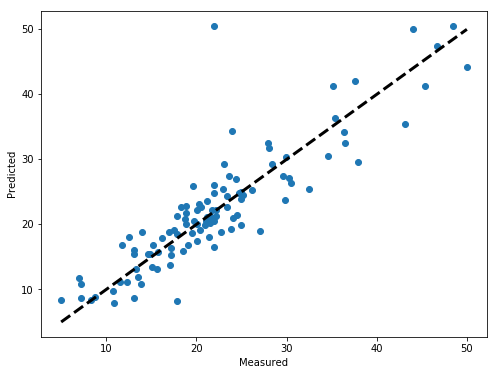

In [167]:
pred_y = sess.run(y_, feed_dict = {X:test_x, keep_prob:1.0})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

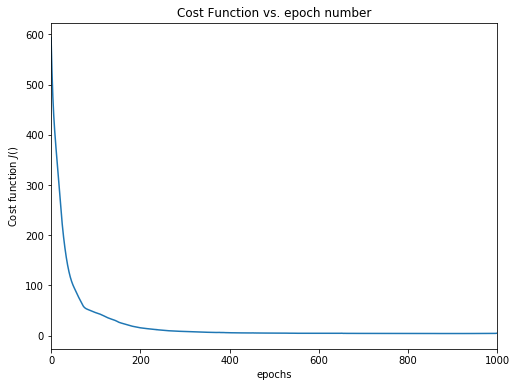

In [168]:
plt.figure(figsize=(8,6))
plt.title("Cost Function vs. epoch number")
plt.xlabel("epochs")
plt.ylabel("Cost function $J()$")
plt.xlim((0,1000))
plt.plot(range(len(cost_history_adam)), cost_history_adam)

MSE: 3.1465


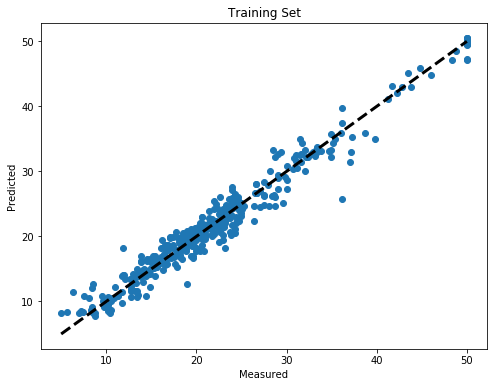

In [170]:
pred_y = sess.run(y_, feed_dict = {X:train_x, keep_prob : 1})
mse = tf.reduce_mean(tf.square(pred_y - train_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_title('Training Set')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [171]:
sess.close()

# Tensorboard integration

In [172]:
tf.reset_default_graph()

learning_rate = 0.1


# Number of neurons in the layers
n1 = 10
n2 = 10

cost_history = np.empty(shape=[1], dtype = float)

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
W1 = tf.Variable(tf.random_normal([n1, n_dim], stddev=1))
b1 = tf.Variable(tf.ones([n1,1]))
W2 = tf.Variable(tf.random_normal([n2, n1], stddev=1))
b2 = tf.Variable(tf.ones([n2,1]))
W3 = tf.Variable(tf.random_normal([1, n2], stddev=1))
b3 = tf.Variable(tf.ones(1))



# Let's build our network...
Z1 = tf.nn.sigmoid(tf.matmul(W1, X) + b1)
Z2 = tf.nn.sigmoid(tf.matmul(W2, Z1) + b2)
y_ = tf.matmul(W3, Z2) + b3

keep_prob = tf.placeholder(tf.float32)


cost = tf.reduce_mean(tf.square(y_-Y))

tf.summary.scalar("cost_function", cost)
merged_summary_op = tf.summary.merge_all()


gd = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [173]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter('/Users/umberto/logs/run1010', graph=tf.get_default_graph())

kp = 0.75
training_epochs = 5000
visualisation_step = 100
    
print ('Adam optimisation')
cost_history_adam = []
for epoch in range(training_epochs+1):
    _, c, summary = sess.run([optimizer, cost, merged_summary_op], feed_dict = {X: train_x, Y: train_y, keep_prob : kp})
    cost_ = sess.run(cost, feed_dict={ X:train_x, Y: train_y, keep_prob : kp})
    cost_history_adam = np.append(cost_history_adam, cost_)
    
    writer.add_summary(summary, epoch )
    
    
    if (epoch % visualisation_step == 0):
        print("Reached epoch",epoch,"cost J =", cost_)

Adam optimisation
Reached epoch 0 cost J = 471.756
Reached epoch 100 cost J = 31.6268
Reached epoch 200 cost J = 8.44229
Reached epoch 300 cost J = 3.46814
Reached epoch 400 cost J = 2.68789
Reached epoch 500 cost J = 2.33569
Reached epoch 600 cost J = 2.17746
Reached epoch 700 cost J = 2.04725
Reached epoch 800 cost J = 1.94685
Reached epoch 900 cost J = 1.88575
Reached epoch 1000 cost J = 1.87408
Reached epoch 1100 cost J = 1.76405
Reached epoch 1200 cost J = 1.67066
Reached epoch 1300 cost J = 1.60961
Reached epoch 1400 cost J = 1.55579
Reached epoch 1500 cost J = 1.52018
Reached epoch 1600 cost J = 1.4957
Reached epoch 1700 cost J = 1.46433
Reached epoch 1800 cost J = 1.44419
Reached epoch 1900 cost J = 1.42278
Reached epoch 2000 cost J = 1.40705
Reached epoch 2100 cost J = 1.38355
Reached epoch 2200 cost J = 1.3651
Reached epoch 2300 cost J = 1.34361
Reached epoch 2400 cost J = 1.32136
Reached epoch 2500 cost J = 1.308
Reached epoch 2600 cost J = 1.31027
Reached epoch 2700 cost J 

MSE: 18.7875


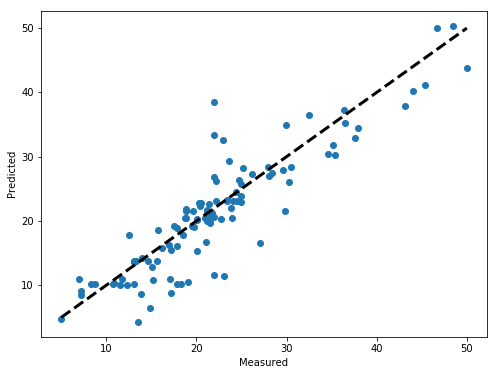

In [174]:
pred_y = sess.run(y_, feed_dict = {X:test_x, keep_prob:1})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()